# SI 618 Final Project Report

Team member:

|  Name  |  uniqname |   UMID  |
|:------|:-------|:-------|
| Yung-Yi (Cerise) Huang | superb |  33013500 | 
| Ming-Jan (Randy) Pan | mjpan  |  91936606 | 

## 1. Introduction

### 1.1 Background and Motivation

Childhood obesity is a pressing issue in the US. The CDC contends that the current percentage of obese children and adolescents is much too high; for years 2017 to 2020, 19.7% of children and adolescents in the US were obese, accounting for 14.7 million children and adolescents.

#### SNAP, dietary habits, and obesity

The Supplemental Nutrition Assistance Program is a nutrition program in the United States that provides benefits to eligible populations for purchasing food items in authorized retail stores. 
There has been ongoing research about the impact of SNAP on the nutrition and dietary habits of families receiving SNAP benefits. One of the active ongoing research areas is the relationship between SNAP benefits and obesity as well as several other social determinant factors. However, researcher have not reached a consensus as to the relationship between SNAP benefits and obesity rates (De Araujo, 2020). Therefore, we wish to further delve into this issue using state level data. 

#### Walkability, physical activity, and obesity

There exists a wide variation in the definition of walkability. However, in its essence, walkability can be understood as a neighborhood’s physical and social attributes and capacity that support lifestyle physical activity, mainly through traveling between destinations by walking (Hall and Ram, 2018). 
In this project, we utilized the walkability scores calculated by the Walk Score service. The scores are calculated using a specialized algorithm that takes into account various regional factors, such as interaction density, average block length, neighborhood amenities, and so on (Walk Score, 2011). Walk Score has been used in various research settings as a proxy measurement for neighborhood walkability. However, there is currently a lack of research on the relationship between the scores generated by the Walk Score service and the physical activities of people of all ages. Therefore, in this project, we aim to examine this relationship, specifically in students in grades 9-12. 


### 1.2 Research Questions

Some questions we wish to answer are:
1. How do physical activity, dietary habits, and weight status surveillance results change over time for each state in the US? 
2. Does having higher average SNAP benefits per person make for better dietary habits?
3. Does having higher state walkability increase overall physical activity?

## 2. Data Collection and Preprocessing

### 2.1 Datasets

In this project, we utilized 4 datasets to answer our questions as well as make visualizations. The datasets and their acquisition methods are listed below:

| Dataset  | Source | Description | Shape (rows, cols) | Missing data % | 
| -- | -- | -- | -- | -- | 
| **[Primary dataset - Nutrition, Physical Activity, and Obesity - Youth Risk Behavior Surveillance System](https://data.cdc.gov/Nutrition-Physical-Activity-and-Obesity/Nutrition-Physical-Activity-and-Obesity-Youth-Risk/vba9-s8jp)** | **CDC<sup>1</sup>** | **This dataset contains surveillance of adolescents’ (9th-12th grade) physical activity, diet, and weight statuses aggregated on the state level and stratified by gender, race/ethnicity, and grade from 2001 to 2019. This dataset is directly downloaded from CDC website** | **(39760, 25)**	 | **19.47** |  
| [Demographics and the Economy Indicators Supplemental Nutrition Assistance Program (SNAP)](https://www.kff.org/state-category/demographics-and-the-economy/supplemental-nutrition-assistance-program/) | KFF<sup>2</sup> | This dataset contains the statistics on the SNAP program (yearly average enrollment, total benefits, and benefits per person). The data is crawled from the Kaiser Family Foundation website using the selenium library<sup>3</sup>.  | (1134, 5) |  0.035 | 
| [City and Neighborhood Walkability Rankings](https://www.walkscore.com/cities-and-neighborhoods/states/) | Walk Score | This dataset contains walkability and bike score of each state. The original data contains walkability score at the county level, which will be aggregated to state level in our analysis process. | (2500, 7) | 8.51 |
| [Cartographic Boundary Files - Shapefile (2022), County level, resolution 1:500,000](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html) | US Census Bureau | This dataset contains the cartographic geometry for all US counties at 1:500,000 resolution to plot choropleth maps. This dataset is processed using the geopandas package. This dataset is obtained directly from the census bureau |(56, 5)  | 0.0 |

<sup>1</sup> CDC: Centers for Disease Control and Prevention\
<sup>2</sup> KFF: Kaiser Family Foundation\
<sup>3</sup> The code for crawling the data is in the `get_data.py` file within the `data` folder.

## 3. Data Analysis and Visualization

### Data Manipulation

1. Dropping rows and columns not relevant to the analysis: For all geographical data, we dropped all data points for Guam, as it is neither a US state nor a special case like the District of Columbia. We also dropped columns containing too many null values or redundant data. 
1. String manipulation: For data crawled from KFF, the data contains footnote annotations and dollar signs ($). We removed the footnote annotation and dollar signs using string manipulation built into pandas’ `.str` accessor. 
1. Data type casting: We also conducted data type casting to make sure the data are in the correct format for numerical analysis

### Data Analysis

1. Grouping, aggregation, and pivot tables: to analyze longitudinal trends of SNAP benefits, walkability, and youth physical activity, overweight status, and dietary habits at different geographical levels (state and national), we used grouping, pivot tables, and aggregation methods. 
1. Natural Jenks Breaks for choropleth mapping: We fitted the natural Jenks Breaks algorithm on the data that are visualized through choropleth maps. We chose this specific method over quantile based cutting method as it minimizes the variances within a class and maximizes the variances between the groups, which allows the accurate representation of group structure in the data. Also, Natural Jenks Breaks is a method widely used in cartographical mapping (Brewer and Pickle, 2002). 
1. Ordinary least squares regression: We used the ordinary least squares regression test to analyze relationships between variables as well as intercept and slope of each variable. 
1. ANOVA test: In order to compare means for a given variable between different groups, we conducted the ANOVA test. We also conducted the Shapiro-Wilk’s test of normality and Levene’s test of homoscedasticity to test that the assumptions for ANOVA test are met. We then adapted different variations of the ANOVA test if the data does not meet the assumption of the ANOVA test.



### 3.1 Data Preparation

In [1]:
import pandas as pd
from IPython import display
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import geopandas as gpd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from jenkspy import JenksNaturalBreaks
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from tqdm import tqdm
import imageio
import os
from scipy import stats

import requests
import warnings
warnings.filterwarnings("ignore")

In [2]:
snap_df = pd.read_csv("../data/SNAP_data_raw.csv")

snap_df["Average Monthly SNAP Benefits per Participant"] = (
    snap_df["Average Monthly SNAP Benefits per Participant"]
    .str.removeprefix("$")
    .replace("N/A", np.nan)
    .astype("float32")
)

snap_df["Average Monthly SNAP Participants"] = (
    snap_df["Average Monthly SNAP Participants"]
    .str.removesuffix(" 1")
    .str.replace(",", "")
    .replace("N/A", np.nan)
    .astype("float32")
)

snap_df["Total Benefits"] = (
    snap_df["Total Benefits"]
    .str.removeprefix("$")
    .str.replace(",", "")
    .str.removesuffix(" 1")
    .replace("N/A", np.nan)
    .astype("int64")
)

snap_df["year"] = snap_df["year"].astype("int16")

snap_df.drop("Unnamed: 0", axis=1, inplace=True)

# geometry shape file - state level
sgdf = gpd.read_file("../data/cb_2022_us_state_500k/cb_2022_us_state_500k.shp")
sgdf = sgdf.drop(['ALAND', 'AWATER','GEOID', 'AFFGEOID', 'STATENS'], axis=1)

In [3]:
df_nutri = pd.read_csv("../data/nutrition_activity.csv")

# YearStart and YearEnd contain the same data
assert (df_nutri["YearEnd"] != df_nutri["YearStart"]).sum() == 0

# We give the columns dropped and reasons for dropping
# 1. Data_Value_Unit: Contains all null data
# 2. Total
# 3. Data_Value_Type
# 4. Geolocation: Shape file will be merged externally for choropleth mapping
# 5. YearEnd: Contains the same data as "YearStart"
# 6. Datasource: Contains the same vale: "Youth Risk Behavior Surveillance System"
df_nutri.drop(
    [
        "Data_Value_Unit",
        "Total",
        "Data_Value_Type",
        "GeoLocation",
        "YearEnd",
        "Datasource",
    ],
    axis=1,
    inplace=True,
)
df_nutri = df_nutri.query("LocationDesc != 'Guam'")

In [4]:
df_walk = pd.read_csv("../data/walkability.csv")

In [5]:
# get the shape and missing data percentage of all dataframes 
pd.DataFrame(
    {
        "Nutrition data (CDC)": [
            df_nutri.shape,
            (df_nutri.isna().sum().sum() / (df_nutri.shape[0] * df_nutri.shape[1])) * 100,
        ],
        "City Walkability and Bikability": [
            df_walk.shape,
            (df_walk.isna().sum().sum() / (df_walk.shape[0] * df_walk.shape[1])) * 100,
        ],
        "SNAP Benefits statistics": [
            snap_df.shape,
            (snap_df.isna().sum().sum() / (snap_df.shape[0] * snap_df.shape[1])) * 100,
        ],
        "Cartographic Boundary Files - State Level": [
            sgdf.shape,
            (sgdf.isna().sum().sum() / (sgdf.shape[0] * sgdf.shape[1])) * 100,
        ],
    }
).T.rename(columns={0: "Shape (rows, cols)", 1: "% missing data"})

,"Shape (rows, cols)",% missing data
Nutrition data (CDC),"(39760, 25)",19.469215
City Walkability and Bikability,"(2500, 7)",8.508571
SNAP Benefits statistics,"(1134, 5)",0.035273
Cartographic Boundary Files - State Level,"(56, 5)",0.0


### 3.2 Question 1

*How do physical activity, dietary habits, and weight status surveillance results change over time for each state in the US?*

Unique questions in the dataset:

|    | ClassID   | Class                   | QuestionID   | Question                                                                                                                    |
|---:|:----------|:------------------------|:-------------|:----------------------------------------------------------------------------------------------------------------------------|
|  0 | FV        | Fruits and Vegetables   | Q020         | Percent of students in grades 9-12 who consume fruit less than 1 time daily                                                 |
|  1 | FV        | Fruits and Vegetables   | Q021         | Percent of students in grades 9-12 who consume vegetables less than 1 time daily                                            |
|  2 | OWS       | Obesity / Weight Status | Q038         | Percent of students in grades 9-12 who have obesity                                                                         |
|  3 | OWS       | Obesity / Weight Status | Q039         | Percent of students in grades 9-12 who have an overweight classification                                                    |
|  4 | PA        | Physical Activity       | Q048         | Percent of students in grades 9-12 who achieve 1 hour or more of moderate-and/or vigorous-intensity physical activity daily |
|  5 | PA        | Physical Activity       | Q049         | Percent of students in grades 9-12 who participate in daily physical education                                              |
|  6 | SD        | Sugar Drinks            | Q058         | Percent of students in grades 9-12 who drank regular soda/pop at least one time per day                                     |
|  7 | TV        | Television Viewing      | Q059         | Percent of students in grades 9-12 watching 3 or more hours of television each school day                                   |

(table generated with code:

```python
print(df_nutri.groupby(["ClassID", "QuestionID"])["Question"]
      .unique()
      .reset_index()
      .explode("Question")
      .to_markdown())
```

)



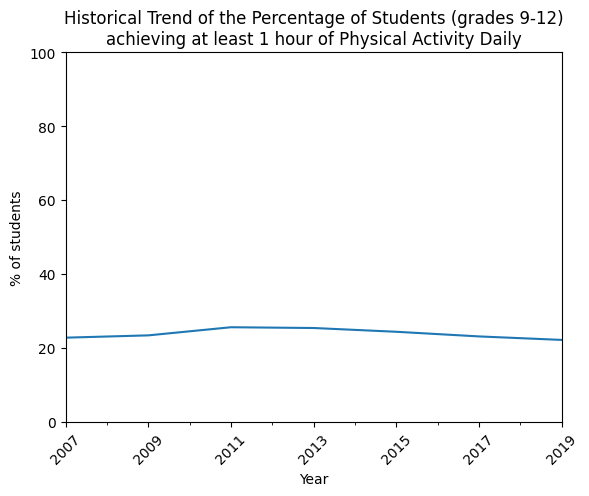

In [6]:
physical_act_trend = (
    pd.pivot_table(
        df_nutri.query("QuestionID == 'Q048'"),
        index="YearStart",
        columns="QuestionID",
        values="Data_Value",
    )
    .reset_index()
    .assign(YearStart=lambda x: pd.to_datetime(x["YearStart"], format="%Y"))
)

register_matplotlib_converters()  # This is needed for pandas datetime

# Plotting
ax = physical_act_trend.plot.line(x="YearStart")
ax.set_title(
    "Historical Trend of the Percentage of Students (grades 9-12)\nachieving at least 1 hour of Physical Activity Daily"
)
xticks = pd.date_range(
    start=physical_act_trend["YearStart"].min(), end="2020-01-01", freq="2Y"
)
ax.set_xticks(xticks)
ax.set_xticklabels([x.strftime("%Y") for x in xticks], rotation=45)
plt.xlabel('Year')
plt.ylabel("% of students")
ax.set_ylim(0, 100)
ax.get_legend().remove()

*In this line plot showing yearly changes in the percentages of students grades 9-12 that achieve at least 1 hour of moderate to vigorous physical activity, it can be observed that there is no significant changes over the years.*

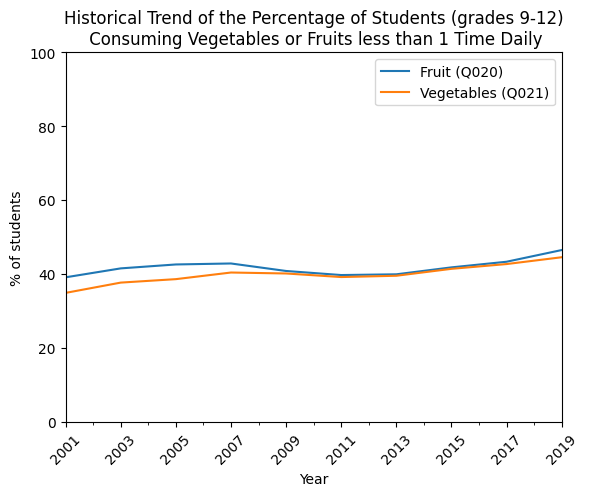

In [7]:
vegetable_trend = (
    pd.pivot_table(
        df_nutri.query("ClassID == 'FV'"),
        index="YearStart",
        columns="QuestionID",
        values="Data_Value",
    )
    .reset_index()
    .assign(YearStart=lambda x: pd.to_datetime(x["YearStart"], format="%Y"))
)

register_matplotlib_converters()  # This is needed for pandas datetime

# Plotting
ax = vegetable_trend.plot.line(x="YearStart")
ax.set_title(
    "Historical Trend of the Percentage of Students (grades 9-12)\n Consuming Vegetables or Fruits less than 1 Time Daily"
)
xticks = pd.date_range(
    start=vegetable_trend["YearStart"].min(), end="2020-01-01", freq="2Y"
)
ax.set_xticks(xticks)
ax.set_xticklabels([x.strftime("%Y") for x in xticks], rotation=45)
plt.xlabel('Year')
plt.ylabel("% of students")
ax.set_ylim(0, 100)
L = plt.legend()
L.get_texts()[0].set_text("Fruit (Q020)")
L.get_texts()[1].set_text("Vegetables (Q021)")

*In this line plot showing yearly changes in the percentages of students grades 9-12 that consume fruits or vegetables less that 1 time per day, it can be observed that there was a slight drop in the percentage of students who consumed fruits or vegetables less than 1 time per day from years 2007 to 2011. After this drop, the percentage of students who consumed fruits or vegetables less than 1 time per day has been rising steadily since the year 2011.*

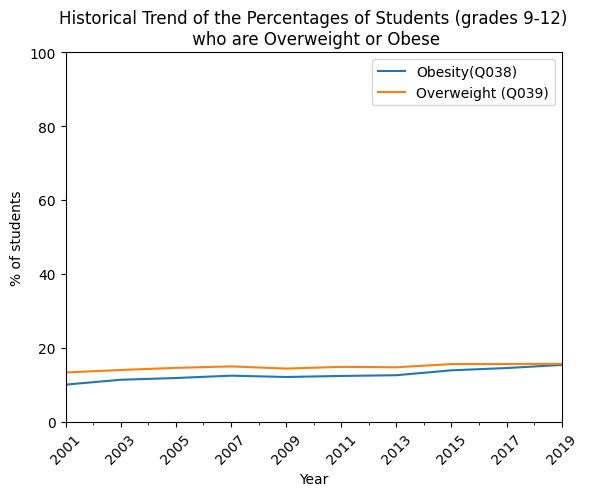

In [8]:
obesity_trend = (
    pd.pivot_table(
        df_nutri.query("ClassID == 'OWS' & Stratification1 == 'Total'"),
        index="YearStart",
        columns="QuestionID",
        values="Data_Value",
    )
    .reset_index()
    .assign(YearStart=lambda x: pd.to_datetime(x["YearStart"], format="%Y"))
)

register_matplotlib_converters()  # This is needed for pandas datetime

# Plotting
ax = obesity_trend.plot.line(x="YearStart")
ax.set_title("Historical Trend of the Percentages of Students (grades 9-12)\n who are Overweight or Obese")
xticks = pd.date_range(
    start=obesity_trend["YearStart"].min(), end="2020-01-01", freq="2Y"
)
ax.set_xticks(xticks)
ax.set_xticklabels([x.strftime("%Y") for x in xticks], rotation=45)
plt.xlabel('Year')
plt.ylabel("% of students")
ax.set_ylim(0, 100)
L = plt.legend()
L.get_texts()[0].set_text("Obesity(Q038)")
L.get_texts()[1].set_text("Overweight (Q039)")

*From this plot portraying percentages of overweight and obese students (grades 9-12) from 2001 to 2019, it may be observed that there is a slight but steady increase in the number of students who are obese. Initially, there was a higher percentage of overweight students compared to obese students, but looking at the year 2019, it would seem that the percentages of overweight and obese students are very close.*

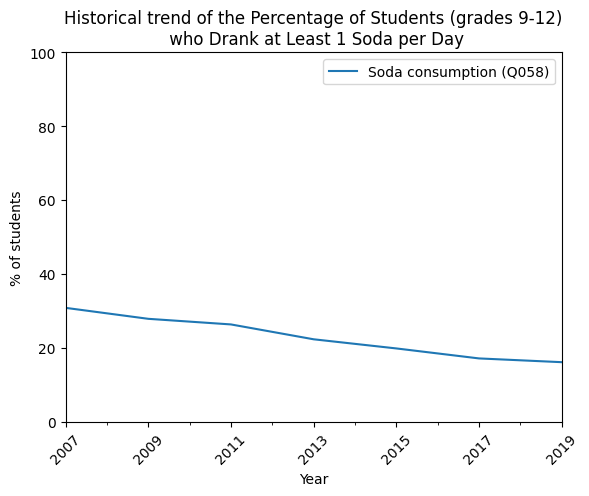

In [9]:
soda_trend = (
    pd.pivot_table(
        df_nutri.query("ClassID == 'SD'"),
        index="YearStart",
        columns="QuestionID",
        values="Data_Value",
    )
    .reset_index()
    .assign(YearStart=lambda x: pd.to_datetime(x["YearStart"], format="%Y"))
)

register_matplotlib_converters()  # This is needed for pandas datetime

# Plotting
ax = soda_trend.plot.line(x="YearStart")
ax.set_title("Historical trend of the Percentage of Students (grades 9-12)\n who Drank at Least 1 Soda per Day")
xticks = pd.date_range(start=soda_trend["YearStart"].min(), end="2020-01-01", freq="2Y")
ax.set_xticks(xticks)
ax.set_xticklabels([x.strftime("%Y") for x in xticks], rotation=45)
plt.xlabel('Year')
plt.ylabel("% of students")
ax.set_ylim(0, 100)
L = plt.legend()
L.get_texts()[0].set_text("Soda consumption (Q058)")

*Between years 2007 to 2019, the percentage of students (grades 9-12) who drank at least 1 soda per day seems to have dropped approximately 10%.*

### Choropleth mapping

In [10]:
!mkdir ../viz_raw/
!mkdir ../viz_raw/ovw_status/

# Overweight
ovw_hist = (
    df_nutri.query("ClassID == 'OWS' & Stratification1 == 'Total'")
    [['YearStart', 'Data_Value', 'QuestionID', 'LocationAbbr', 'LocationDesc']]
    .query("(QuestionID == 'Q039') & ~(Data_Value.isnull())", engine='python')
)

jnb = JenksNaturalBreaks(5)
jnb.fit(ovw_hist['Data_Value'])

# construct list of break ranges to put in plot legend
cls = []
for i in range(len(jnb.breaks_)):
     try: 
          a = str(round(jnb.breaks_[i], 1))
          b = str(round(jnb.breaks_[i+1], 1))
          cls.append(f"{a}-{b}")
     except:
          pass

# assign class breaks to each data point and merge with dataframe containing geometry for plotting 
ovw_hist['cls'] = ovw_hist['Data_Value'].apply(lambda x: "abcde"[jnb.predict(x)])
ovw_gdf = sgdf[['STUSPS', 'geometry']].merge(ovw_hist, how="right", left_on="STUSPS", right_on="LocationAbbr")

# 1. Create a complete list of state-year combinations
all_states = sgdf["STUSPS"].unique()
all_years = ovw_hist["YearStart"].unique()

# Cartesian product of states and years
state_years = pd.MultiIndex.from_product(
    [all_states, all_years], names=["LocationAbbr", "YearStart"]
).to_frame(index=False)

# 2. Merge this list with your data
augmented_death_df = state_years.merge(ovw_hist, on=["LocationAbbr", "YearStart"], how="left")
# augmented_death_df['Data_Value'] = augmented_death_df['Data_Value'].fillna(1e-3)
augmented_death_df['cls'] = augmented_death_df['cls'].fillna("x")

ovw_gdf = sgdf.merge(
    (augmented_death_df.groupby(["LocationAbbr", "cls", "YearStart"])["Data_Value"].mean().reset_index()),
    how="left",
    left_on="STUSPS",
    right_on="LocationAbbr",
)

# dropping US Territories and commonwealth areas 
ovw_gdf = ovw_gdf.drop(
    ovw_gdf[
        ovw_gdf["STUSPS"].isin(['AS', 'GU', 'MP', 'PR', 'VI', 'UM'])
    ].index
)

# get the vertical min and max for histogram 
vmin = ovw_gdf["Data_Value"].min()
vmax = ovw_gdf["Data_Value"].max()

# set colormap and colors for the map
colmap = plt.cm.Reds
plot_color = [mcolors.to_hex(c) for c in colmap([0.2, 0.4, 0.6, 0.8, 1.0])]  + [
    "#CCCCCC"
]
color_dict = {i: c for i, c in zip(['a', 'b', 'c', 'd', 'e', 'x'], plot_color)}

# loop through YearStart numbers to plot the data for that given year. For opioid dispensation,
# the data range is 2006-2020
plot_extra = True
for i in tqdm(range(2001, 2021, 2)):
    # use a subplot to hold all figures
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))
    # plot data for the US main territory using the CRS coordinate system, EPSG number 2163
    filtered_data = ovw_gdf[~(ovw_gdf["LocationAbbr"].isin(["AK", "HI"])) & (ovw_gdf["YearStart"] == i)].to_crs(epsg=2163)
    filtered_data.plot(
        column="cls",
        categorical=True,
        color = filtered_data["cls"].map(color_dict),
        legend=True,
        ax=ax,
        legend_kwds={"frameon": False, "labels": cls, 'loc':'lower right'},
        edgecolor="k",
    )
    # set legend patches
    legend_patches = [ Patch(color=color_dict[cls], label=cls) for cls in ['a', 'b', 'c', 'd', 'e']]
    legend_patches.append(Patch(color="#CCCCCC", label="No data"))
    ax.legend(handles=legend_patches, frameon=False, loc='lower right', labels=cls + ['No data'])
    filtered_data.apply(lambda x: ax.annotate(text=x['LocationAbbr'], 
                                              xy=x.geometry.centroid.coords[0], 
                                              ha='center'), axis=1)
    # configure plot: disable grid lines, tick labels, and axis lines, set title, and configure plot position
    ax.grid(False)
    ax.axis("off")
    ax.set_title(
        f"% of students who are overweight, {i}", fontdict={"fontsize": 25}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    # shift the plot to make space for other plots
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    # plot data for Alaska using the CRS coordinate system, EPSG number 3338 
    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.2])
    ovw_gdf[(ovw_gdf["LocationAbbr"] == "AK") & (ovw_gdf["YearStart"] == i)].to_crs(
        epsg=3338
    ).plot(
        column="cls",
        categorical=True,
        color = filtered_data["cls"].map(color_dict),
        ax=ax_ak,
        edgecolor="k",
    )
    # configure plot: disable grid lines, tick labels, and axis lines, 
    # set title, and configure plot position
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to Alaska's coordinates to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    # plot data for Hawaii using the CRS coordinate system, EPSG number 4326 
    ax_hi = fig.add_axes([0.59, 0.05, 0.2, 0.2])
    ovw_gdf[(ovw_gdf["LocationAbbr"] == "HI") & (ovw_gdf["YearStart"] == i)].to_crs(
        epsg=4326
    ).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        ax=ax_hi,
        edgecolor="k",
        aspect=1
    )
    # configure plot: disable grid lines, tick labels, and axis lines, 
    # set title, and configure plot position
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        # add line graph to show historical dispensing rate trend
        ax_lg = fig.add_axes([1, 0.58, 0.3, 0.27])
        ax_lg.set_ylim(9.5, 16.5)
        # construct a YearStartly mean value dataframe
        mean_df = (
            ovw_gdf.groupby("YearStart")["Data_Value"]
            .mean()
            .reset_index()
        )
        # format the YearStart column in the mean_df dataframe
        mean_df["YearStart"] = pd.to_datetime(mean_df["YearStart"], format="%Y")
        xticks = pd.date_range(
            start=mean_df["YearStart"].min(), end="2020-01-01", freq="2Y"
        )
        # plot the historical trend
        mean_df[["YearStart", "Data_Value"]].plot(
            x="YearStart", y="Data_Value", ax=ax_lg
        )
        ax_lg.vlines(
            pd.to_datetime(i, format='%Y'),
            0,
            100,
            "#cccccc",
        )
        ax_lg.set_xticks(xticks)
        ax_lg.set_xticklabels([x.strftime("%Y") for x in xticks], rotation=45, ha="right")
        # set title, ylabel, and annotation texts
        ax_lg.set_title("Yearly trend of national mean student overweight rate")
        ax_lg.set_ylabel("Percent")
        ax_lg.annotate(
            f"{i} Mean: {str(round(mean_df.loc[(i - 2001) // 2]['Data_Value'], 1))}",
            xy=(pd.to_datetime(2010, format="%Y"), 11),
        )
        # remove legend
        ax_lg.get_legend().remove()

        # draw histogram of dispensing rate of YearStart
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        # plot the histogram
        ovw_gdf[ovw_gdf["YearStart"] == i]["Data_Value"].plot(
            kind="hist", ax=ax_hist, bins=15
        )
        # set title and limits for x and y axis
        ax_hist.set_title(f"Distribution of percentage of overweight student in {i}")
        ax_hist.set_xlim(0, vmax)
        ax_hist.set_ylim(0, 15)
        ax_hist.set_xlabel("Percent")
    # configure layout of the visualization and save to directory 
    plt.tight_layout()
    # plt.show()
    plt.savefig(f"../viz_raw/ovw_status/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

# combine all historical visualizations into one animation
fname = "../viz/2001_2019_ovw_status.gif"
print("generating animation...")
with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in tqdm(sorted([f for f in os.listdir(os.curdir + "./viz_raw/ovw_status/") if os.path.isfile(os.curdir + "./viz_raw/ovw_status/" + f)])):
        image = imageio.imread("../viz_raw/ovw_status/" + filename)
        writer.append_data(image)

!convert -loop 0 ../viz/2001_2019_ovw_status.gif ../viz/_present_2001_2019_ovw_status.gif

mkdir: ../viz_raw/: File exists


mkdir: ../viz_raw/ovw_status/: File exists


100%|██████████| 10/10 [00:27<00:00,  2.70s/it]


generating animation...


100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


This GIF may take a while to load. If it fails to load, please visit [this link](https://github.com/AxueWithoutU/SI-618-Project/blob/master/viz/_present_2001_2019_ovw_status.gif)
<img src="https://github.com/AxueWithoutU/SI-618-Project/blob/master/viz/_present_2001_2019_ovw_status.gif?raw=true"></img>
<!-- ![Choropleth maps of US overweight students (grades 9-12)](../viz/_present_2001_2019_ovw_status.gif) -->

*From this GIF, it may be inferred that between the years 2001 to 2019, the percentage of students (grades 9-12) who are overweight has seen increases in the southern states (e.g. Texas, Oklahoma, Alabama).*

In [11]:
!mkdir ../viz_raw/obs_status/
# Obesity
ovw_hist = (
    df_nutri.query("ClassID == 'OWS' & Stratification1 == 'Total'")
    [['YearStart', 'Data_Value', 'QuestionID', 'LocationAbbr', 'LocationDesc']]
    .query("(QuestionID == 'Q038') & ~(Data_Value.isnull())", engine='python')
)

jnb = JenksNaturalBreaks(5)
jnb.fit(ovw_hist['Data_Value'])

# construct list of break ranges to put in plot legend
cls = []
for i in range(len(jnb.breaks_)):
     try: 
          a = str(round(jnb.breaks_[i], 1))
          b = str(round(jnb.breaks_[i+1], 1))
          cls.append(f"{a}-{b}")
     except:
          pass

# assign class breaks to each data point and merge with dataframe containing geometry for plotting 
ovw_hist['cls'] = ovw_hist['Data_Value'].apply(lambda x: "abcde"[jnb.predict(x)])
ovw_gdf = sgdf[['STUSPS', 'geometry']].merge(ovw_hist, how="right", left_on="STUSPS", right_on="LocationAbbr")

# 1. Create a complete list of state-year combinations
all_states = sgdf["STUSPS"].unique()
all_years = ovw_hist["YearStart"].unique()

# Cartesian product of states and years
state_years = pd.MultiIndex.from_product(
    [all_states, all_years], names=["LocationAbbr", "YearStart"]
).to_frame(index=False)

# 2. Merge this list with your data
augmented_death_df = state_years.merge(ovw_hist, on=["LocationAbbr", "YearStart"], how="left")
augmented_death_df['cls'] = augmented_death_df['cls'].fillna("x")

ovw_gdf = sgdf.merge(
    (
        augmented_death_df.groupby(["LocationAbbr", "cls", "YearStart"])["Data_Value"]
        .mean()
        .reset_index()
    ),
    how="left",
    left_on="STUSPS",
    right_on="LocationAbbr",
)

# dropping US Territories and commonwealth areas 
ovw_gdf = ovw_gdf.drop(
    ovw_gdf[
        ovw_gdf["STUSPS"].isin(['AS', 'GU', 'MP', 'PR', 'VI', 'UM'])
    ].index
)

# get the vertical min and max for histogram 
vmin = ovw_gdf["Data_Value"].min()
vmax = ovw_gdf["Data_Value"].max()

# set colormap and colors for the map
colmap = plt.cm.YlOrBr
plot_color = [mcolors.to_hex(c) for c in colmap([0.2, 0.4, 0.6, 0.8, 1.0])]  + [
    "#CCCCCC"
]
color_dict = {i: c for i, c in zip(['a', 'b', 'c', 'd', 'e', 'x'], plot_color)}

# loop through YearStart numbers to plot the data for that given year. For opioid dispensation,
# the data range is 2006-2020
plot_extra = True
for i in tqdm(range(2001, 2021, 2)):
    # use a subplot to hold all figures
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))
    # plot data for the US main territory using the CRS coordinate system, EPSG number 2163
    filtered_data = ovw_gdf[~(ovw_gdf["LocationAbbr"].isin(["AK", "HI"])) & (ovw_gdf["YearStart"] == i)].to_crs(epsg=2163)
    filtered_data.plot(
        column="cls",
        categorical=True,
        color = filtered_data["cls"].map(color_dict),
        legend=True,
        ax=ax,
        legend_kwds={"frameon": False, "labels": cls, 'loc':'lower right'},
        edgecolor="k",
    )
    # set legend patches
    legend_patches = [Patch(color=color_dict[cls], label=cls) for cls in ['a', 'b', 'c', 'd', 'e']]
    legend_patches.append(Patch(color="#CCCCCC", label="No data"))
    ax.legend(handles=legend_patches, frameon=False, loc='lower right', labels=cls + ['No data'])
    filtered_data.apply(lambda x: ax.annotate(text=x['LocationAbbr'], 
                                              xy=x.geometry.centroid.coords[0], 
                                              ha='center'), axis=1)
    # configure plot: disable grid lines, tick labels, and axis lines, set title, and configure plot position
    ax.grid(False)
    ax.axis("off")
    ax.set_title(
        f"% of students who are obese, {i}", fontdict={"fontsize": 25}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    # shift the plot to make space for other plots
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    # plot data for Alaska using the CRS coordinate system, EPSG number 3338 
    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.2])
    ovw_gdf[(ovw_gdf["LocationAbbr"] == "AK") & (ovw_gdf["YearStart"] == i)].to_crs(
        epsg=3338
    ).plot(
        column="cls",
        categorical=True,
        color = filtered_data["cls"].map(color_dict),
        ax=ax_ak,
        edgecolor="k",
    )
    # configure plot: disable grid lines, tick labels, and axis lines, 
    # set title, and configure plot position
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to Alaska's coordinates to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    # plot data for Hawaii using the CRS coordinate system, EPSG number 4326 
    ax_hi = fig.add_axes([0.59, 0.05, 0.2, 0.2])
    ovw_gdf[(ovw_gdf["LocationAbbr"] == "HI") & (ovw_gdf["YearStart"] == i)].to_crs(
        epsg=4326
    ).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        ax=ax_hi,
        edgecolor="k",
        aspect=1
    )
    # configure plot: disable grid lines, tick labels, and axis lines, 
    # set title, and configure plot position
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        # add line graph to show historical dispensing rate trend
        ax_lg = fig.add_axes([1, 0.58, 0.3, 0.27])
        ax_lg.set_ylim(9.5, 16.5)
        # construct a YearStartly mean value dataframe
        mean_df = (
            ovw_gdf.groupby("YearStart")["Data_Value"]
            .mean()
            .reset_index()
        )
        # format the YearStart column in the mean_df dataframe
        mean_df["YearStart"] = pd.to_datetime(mean_df["YearStart"], format="%Y")
        xticks = pd.date_range(
            start=mean_df["YearStart"].min(), end="2020-01-01", freq="2Y"
        )
        # plot the historical trend
        mean_df[["YearStart", "Data_Value"]].plot(
            x="YearStart", y="Data_Value", ax=ax_lg
        )
        ax_lg.vlines(
            pd.to_datetime(i, format='%Y'),
            0,
            100,
            "#cccccc",
        )
        ax_lg.set_xticks(xticks)
        ax_lg.set_xticklabels([x.strftime("%Y") for x in xticks], rotation=45, ha="right")
        # set title, ylabel, and annotation texts
        ax_lg.set_title("Yearly trend of national mean student obesity rate")
        ax_lg.set_ylabel("Percent")
        ax_lg.annotate(
            f"{i} Mean: {str(round(mean_df.loc[(i - 2001) // 2]['Data_Value'], 1))}",
            xy=(pd.to_datetime(2010, format="%Y"), 11),
        )
        # remove legend
        ax_lg.get_legend().remove()

        # draw histogram of dispensing rate of YearStart
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        # plot the histogram
        ovw_gdf[ovw_gdf["YearStart"] == i]["Data_Value"].plot(
            kind="hist", ax=ax_hist, bins=15
        )
        # set title and limits for x and y axis
        ax_hist.set_title(f"Distribution of percentage of obese student in {i}")
        ax_hist.set_xlim(0, vmax)
        ax_hist.set_ylim(0, 15)
        ax_hist.set_xlabel("Percent")
    # configure layout of the visualization and save to directory 
    plt.tight_layout()
    # plt.show()
    plt.savefig(f"../viz_raw/obs_status/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

# combine all historical visualizations into one animation
fname = "../viz/2001_2019_obs_status.gif"
print("generating animation...")
with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in tqdm(sorted([f for f in os.listdir(os.curdir + "./viz_raw/obs_status/") if os.path.isfile(os.curdir + "./viz_raw/obs_status/" + f)])):
        image = imageio.imread("../viz_raw/obs_status/" + filename)
        writer.append_data(image)

!convert -loop 0 ../viz/2001_2019_obs_status.gif ../viz/_present_2001_2019_obs_status.gif

mkdir: ../viz_raw/obs_status/: File exists


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


generating animation...


100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


The GIF file may take a while to load. If the image does not load, please visit [this link](https://github.com/AxueWithoutU/SI-618-Project/blob/master/viz/_present_2001_2019_obs_status.gif)
<img src="https://github.com/AxueWithoutU/SI-618-Project/blob/master/viz/_present_2001_2019_obs_status.gif?raw=true"></img>
<!-- ![% of students who are obese (grades 9-12)](../viz/_present_2001_2019_obs_status.gif) -->


*From this GIF, it may be inferred that between the years 2001 to 2019, the percentage of students (grades 9-12) who are obese has seen an obvious increase in the southern states (e.g. Texas, Oklahoma, Alabama), moreso than the percentage of students who are overweight.*

In [12]:
# since we are joining using state full name, we verify that all main states
# are valid and the same in the two datasets 
(set(snap_df.Location.unique()).difference(sgdf['NAME'].unique()),
set(sgdf['NAME'].unique()).difference(snap_df.Location.unique()))

({'United States', 'Virgin Islands'},
 {'American Samoa',
  'Commonwealth of the Northern Mariana Islands',
  'Puerto Rico',
  'United States Virgin Islands'})

In [13]:
!mkdir ../viz_raw/snap_status/
# OWS 
ovw_hist = (
    snap_df.query("Location != 'United States'")
    [['Location', 'year', 'Average Monthly SNAP Benefits per Participant']]
    .rename(columns={"Average Monthly SNAP Benefits per Participant": "Data_Value"})
    .query("~(Data_Value.isnull())", engine='python')
)

jnb = JenksNaturalBreaks(7)
jnb.fit(ovw_hist['Data_Value'])

# construct list of break ranges to put in plot legend
cls = []
for i in range(len(jnb.breaks_)):
     try: 
          a = str(round(jnb.breaks_[i], 1))
          b = str(round(jnb.breaks_[i+1], 1))
          cls.append(f"\${a}-\${b}")
     except:
          pass

# assign class breaks to each data point and merge with dataframe containing geometry for plotting 
ovw_hist['cls'] = ovw_hist['Data_Value'].apply(lambda x: "abcdefg"[jnb.predict(x)])
ovw_gdf = sgdf[['NAME',  'geometry']].merge(ovw_hist, how="right", left_on="NAME", right_on="Location")

# 1. Create a complete list of state-year combinations
all_states = sgdf["NAME"].unique()
all_years = ovw_hist["year"].unique()

# Cartesian product of states and years
state_years = pd.MultiIndex.from_product(
    [all_states, all_years], names=["NAME", "year"]
).to_frame(index=False)

# 2. Merge this list with your data
augmented_death_df = state_years.merge(ovw_hist, left_on=["NAME", "year"], right_on=['Location', 'year'], how="left")
augmented_death_df['cls'] = augmented_death_df['cls'].fillna("x")

ovw_gdf = sgdf.merge(
    (augmented_death_df.groupby(["Location", "cls", "year"])["Data_Value"].mean().reset_index()),
    how="inner",
    left_on=['NAME'],
    right_on="Location",
)

# dropping US Territories and commonwealth areas 
ovw_gdf = ovw_gdf.drop(
    ovw_gdf[
        ovw_gdf["Location"].isin(['American Samoa', 
                                  'Guam', 
                                  'Commonwealth of the Northern Mariana Islands',
                                  'Puerto Rico',
                                  'United States Virgin Islands',])
    ].index
)


# get the vertical min and max for histogram 
vmin = ovw_gdf["Data_Value"].min()
vmax = ovw_gdf["Data_Value"].max()

# set colormap and colors for the map
colmap = plt.cm.YlGnBu
plot_color = [mcolors.to_hex(c) for c in colmap(np.linspace(0, 1, 8)[1:])]  + [
    "#CCCCCC"
]
color_dict = {i: c for i, c in zip(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'x'], plot_color)}

# loop through year numbers to plot the data for that given year. For opioid dispensation,
# the data range is 2006-2020
plot_extra = True
# 2023
for i in tqdm(range(2002, 2023)):
    # use a subplot to hold all figures
    fig, ax = plt.subplots(1, 1, figsize=(11, 10))
    # plot data for the US main territory using the CRS coordinate system, EPSG number 2163
    filtered_data = (
        ovw_gdf[~(ovw_gdf["Location"].isin(["Alaska", "Hawaii"])) & 
                (ovw_gdf["year"] == i)].to_crs(epsg=2163)
                )
    
    filtered_data.plot(
        column="cls",
        categorical=True,
        color = filtered_data["cls"].map(color_dict),
        legend=True,
        ax=ax,
        legend_kwds={"frameon": False, "labels": cls, 'loc':'lower right'},
        edgecolor="k",
    )
    # set legend patches
    legend_patches = [Patch(color=color_dict[cls], label=cls) for cls in ['a', 'b', 'c', 'd', 'e', 'f', 'g']]
    legend_patches.append(Patch(color="#CCCCCC", label="No data"))
    ax.legend(handles=legend_patches, 
              frameon=False, 
            #   loc='lower right', 
              labels=cls + ['No data'],
              loc=(0.85, -0.08)
              )
    filtered_data.apply(lambda x: ax.annotate(text=x['STUSPS'], 
                                              xy=x.geometry.centroid.coords[0], 
                                              ha='center'), axis=1)
    # configure plot: disable grid lines, tick labels, and axis lines, set title, and configure plot position
    ax.grid(False)
    ax.axis("off")
    ax.set_title(
        f"Average monthly SNAP benefit per Participant, {i}", fontdict={"fontsize": 25}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    # shift the plot to make space for other plots
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    # plot data for Alaska using the CRS coordinate system, EPSG number 3338 
    ax_ak = fig.add_axes([0.1, 0.14, 0.2, 0.2])
    ovw_gdf[(ovw_gdf["Location"] == "Alaska") & (ovw_gdf["year"] == i)].to_crs(
        epsg=3338
    ).plot(
        column="cls",
        categorical=True,
        color = filtered_data["cls"].map(color_dict),
        ax=ax_ak,
        edgecolor="k",
    )
    # configure plot: disable grid lines, tick labels, and axis lines, 
    # set title, and configure plot position
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to Alaska's coordinates to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    # plot data for Hawaii using the CRS coordinate system, EPSG number 4326 
    ax_hi = fig.add_axes([0.56, 0.12, 0.2, 0.2])
    ovw_gdf[(ovw_gdf["Location"] == "Hawaii") & (ovw_gdf["year"] == i)].to_crs(
        epsg=4326
    ).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        ax=ax_hi,
        edgecolor="k",
        aspect=1
    )
    # configure plot: disable grid lines, tick labels, and axis lines, 
    # set title, and configure plot position
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        # add line graph to show historical dispensing rate trend
        ax_lg = fig.add_axes([1, 0.54, 0.3, 0.27])
        ax_lg.set_ylim(70, 240)
        # construct a yearly mean value dataframe
        mean_df = (
            ovw_gdf.groupby("year")["Data_Value"]
            .mean()
            .reset_index()
        )
        # format the year column in the mean_df dataframe
        mean_df["year"] = pd.to_datetime(mean_df["year"], format="%Y")
        # plot the historical trend
        mean_df[["year", "Data_Value"]].plot(
            x="year", y="Data_Value", ax=ax_lg
        )
        ax_lg.vlines(
            pd.to_datetime(i, format='%Y'),
            0,
            250,
            "#cccccc",
        )

        xticks = pd.date_range(
            start=mean_df["year"].min(), end="2023-01-01", freq="2Y"
        )
        ax_lg.set_xticks(xticks)
        ax_lg.set_xticklabels([x.strftime("%Y") for x in xticks], rotation=45, ha="right")
        # set title, ylabel, and annotation texts
        ax_lg.set_title("Yearly trend of national mean monthly SNAP benefits")
        ax_lg.set_ylabel("Dollars")
        ax_lg.annotate(
            f"{i} Mean: ${str(round(mean_df.loc[(i - 2002)]['Data_Value'], 1))} USD",
            xy=(pd.to_datetime(2004, format="%Y"), 150),
        )
        ax_lg.set_xlabel("Fiscal Year")
        # remove legend
        ax_lg.get_legend().remove()

        # draw histogram of dispensing rate of year
        ax_hist = fig.add_axes([1, 0.17, 0.3, 0.27])
        # plot the histogram
        ovw_gdf[ovw_gdf["year"] == i]["Data_Value"].plot(
            kind="hist", ax=ax_hist, bins=10
        )
        # set title and limits for x and y axis
        ax_hist.set_title(f"Average monthly SNAP benefit per perticipant in {i}")
        ax_hist.set_xlim(0, vmax)
        ax_hist.set_ylim(0, 25)
        ax_hist.set_xlabel("Dollars")
    # configure layout of the visualization and save to directory 
    plt.tight_layout()
    # plt.show()
    plt.savefig(f"../viz_raw/snap_status/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

# combine all historical visualizations into one animation
fname = "../viz/2002_2022_snap_status.gif"
print("generating animation...")
with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in tqdm(sorted([f for f in os.listdir(os.curdir + "./viz_raw/snap_status/") if os.path.isfile(os.curdir + "./viz_raw/snap_status/" + f)])):
        image = imageio.imread("../viz_raw/snap_status/" + filename)
        writer.append_data(image)

!convert -loop 0 ../viz/2002_2022_snap_status.gif ../viz/_present_2002_2022_snap_status.gif

mkdir: ../viz_raw/snap_status/: File exists


100%|██████████| 21/21 [00:58<00:00,  2.77s/it]


generating animation...


100%|██████████| 21/21 [00:11<00:00,  1.85it/s]


This GIF may take a whiel to load. If it fails to load, please visit [this link](https://github.com/AxueWithoutU/SI-618-Project/blob/master/viz/_present_2002_2022_snap_status.gif)
<img src="https://github.com/AxueWithoutU/SI-618-Project/blob/master/viz/_present_2002_2022_snap_status.gif?raw=true"></img>
<!-- ![Average Monthly SNAP benefit per participant, 2002-2022](../viz/_present_2002_2022_snap_status.gif) -->

*Looking at the GIF and the line plot, we may surmise that the monthly SNAP benefit per participant has overall risen over the years across all states.*

### 3.3 Question 2 

Does having higher average SNAP benefits per person make for better dietary habits? 



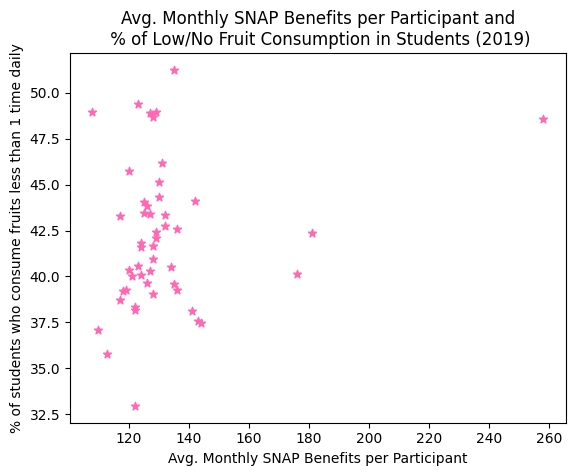

In [14]:
# get 2019 SNAP data
snap_2019 = snap_df.query("year == 2019")
# get data for question regarding daily fruit consumption
fruit = df_nutri.query("QuestionID == 'Q020'")
# merge for snap and fruit year 2019
snap_fruit_2019 = pd.merge(
    snap_2019, fruit, left_on="Location", right_on="LocationDesc", how="left"
)
# get mean monthly snap benefits per participant
sf_2019_ben_mean = (
    snap_fruit_2019.groupby("LocationDesc")[
        "Average Monthly SNAP Benefits per Participant"
    ]
    .mean()
    .to_frame()
    .reset_index()
)

# get mean for percentage of students who consume fruits less than 1 time daily
sf_2019_mean = (
    snap_fruit_2019.groupby("LocationDesc")["Data_Value"]
    .mean()
    .to_frame()
    .reset_index()
)

# plot
plt.scatter(
    sf_2019_ben_mean["Average Monthly SNAP Benefits per Participant"],
    sf_2019_mean["Data_Value"],
    color="hotpink",
    marker="*",
)
plt.xlabel("Avg. Monthly SNAP Benefits per Participant")
plt.ylabel("% of students who consume fruits less than 1 time daily")
plt.title(
    "Avg. Monthly SNAP Benefits per Participant and\n % of Low/No Fruit Consumption in Students (2019)"
);

*Visually, there appears to be very little correlation between the average monthly SNAP benefits per participant and the percentage of students (grades 9-12) who consume fruits less than 1 time daily.*

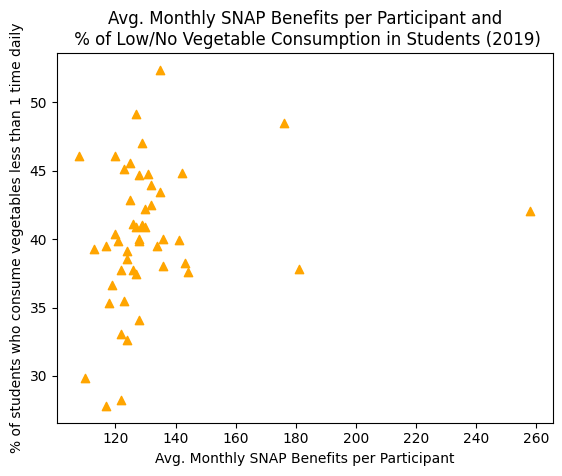

In [15]:
# get data for question regarding daily vegetable consumption
veg = df_nutri.query("QuestionID == 'Q021'")
# merge for snap and veg year 2019
snap_veg_2019 = pd.merge(
    snap_2019, veg, left_on="Location", right_on="LocationDesc", how="left"
)
# get mean monthly snap benefits per participant
sv_2019_ben_mean = (
    snap_veg_2019.groupby("LocationDesc")[
        "Average Monthly SNAP Benefits per Participant"
    ]
    .mean()
    .to_frame()
    .reset_index()
)

# get mean for percentage of students who consume vegetables less than 1 time daily
sv_2019_mean = (
    snap_veg_2019.groupby("LocationDesc")["Data_Value"]
    .mean()
    .to_frame()
    .reset_index()
)

# plot
plt.scatter(
    sv_2019_ben_mean["Average Monthly SNAP Benefits per Participant"],
    sv_2019_mean["Data_Value"],
    color="orange",
    marker="^",
)
plt.xlabel("Avg. Monthly SNAP Benefits per Participant")
plt.ylabel("% of students who consume vegetables less than 1 time daily")
plt.title(
    "Avg. Monthly SNAP Benefits per Participant and\n % of Low/No Vegetable Consumption in Students (2019)"
);

*Visually, there appears to be very little correlation between the average monthly SNAP benefits per participant and the percentage of students (grades 9-12) who consume vegetable less than 1 time daily.*

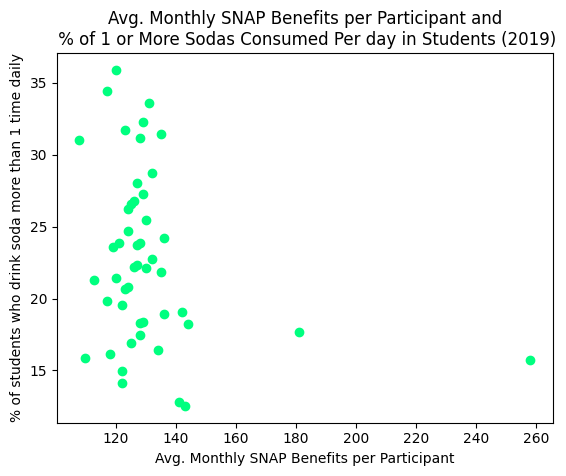

In [16]:
# get data for question regarding daily soda consumption
soda = df_nutri.query("QuestionID == 'Q058'")
# merge for snap and fruit year 2019
snap_soda_2019 = pd.merge(
    snap_2019, soda, left_on="Location", right_on="LocationDesc", how="left"
)
# get mean monthly snap benefits per participant
ss_2019_ben_mean = (
    snap_soda_2019.groupby("LocationDesc")[
        "Average Monthly SNAP Benefits per Participant"
    ]
    .mean()
    .to_frame()
    .reset_index()
)

# get mean for percentage of students who consume fruits less than 1 time daily
ss_2019_mean = (
    snap_soda_2019.groupby("LocationDesc")["Data_Value"]
    .mean()
    .to_frame()
    .reset_index()
)

# plot
plt.scatter(
    ss_2019_ben_mean["Average Monthly SNAP Benefits per Participant"],
    ss_2019_mean["Data_Value"],
    color="springgreen",
    marker="o",
)
plt.xlabel("Avg. Monthly SNAP Benefits per Participant")
plt.ylabel("% of students who drink soda more than 1 time daily")
plt.title(
    "Avg. Monthly SNAP Benefits per Participant and\n % of 1 or More Sodas Consumed Per day in Students (2019)"
);

*Visually, there appears to be very little correlation between the average monthly SNAP benefits per participant and the percentage of students (grades 9-12) who drank more than 1 soda per day.*

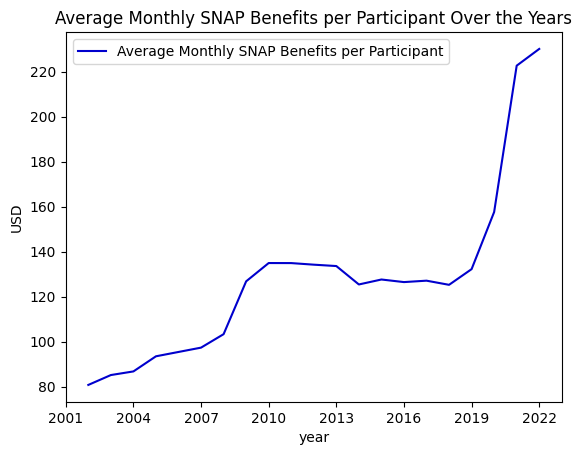

In [17]:
# plot national average monthly SNAP benefits per participant over the years
snap_ben_year = snap_df.groupby('year')['Average Monthly SNAP Benefits per Participant'].mean().to_frame().reset_index()
ax = snap_ben_year.plot.line(x='year', y='Average Monthly SNAP Benefits per Participant', color='mediumblue')
ax.set_title("Average Monthly SNAP Benefits per Participant Over the Years")
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.ylabel('USD');

*As mentioned previously, the monthly SNAP benefit per participant has evidently risen over the years across all states.**

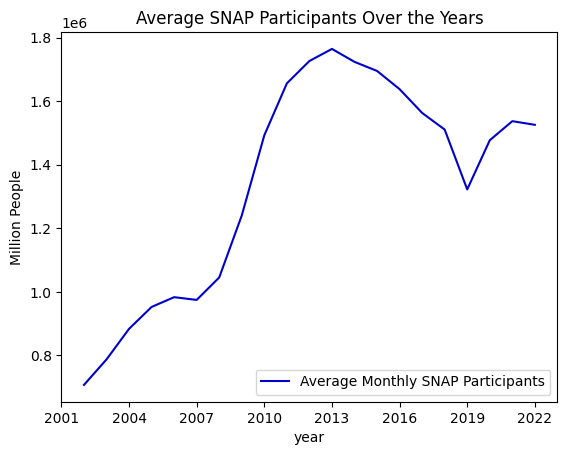

In [18]:
# plot national average monthly SNAP participants over the years
snap_part_year = snap_df.groupby('year')['Average Monthly SNAP Participants'].mean().to_frame().reset_index()
ax = snap_part_year.plot.line(x='year', y='Average Monthly SNAP Participants', color='mediumblue')
ax.set_title("Average SNAP Participants Over the Years")
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.ylabel('Million People');

*In this line plot portraying the change in the average number of SNAP participants over the years, the number of people participating in the program peaked in 2013, experienced a sharp dip in 2019, and then proceeded to rise a little after 2019.*

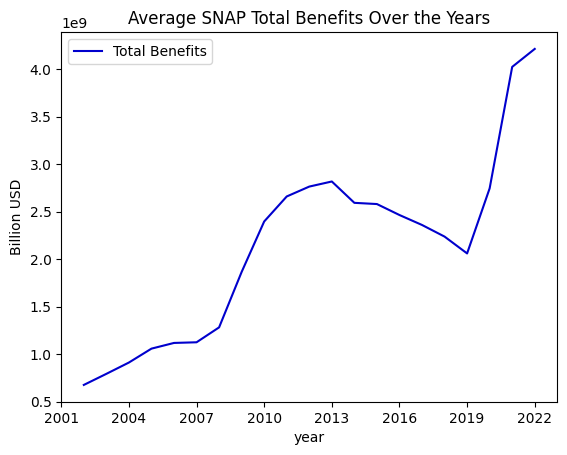

In [19]:
# plot national average total SNAP benefits over the years
snap_total_year = snap_df.groupby('year')['Total Benefits'].mean().to_frame().reset_index()
ax = snap_total_year.plot.line(x='year', y='Total Benefits', color='mediumblue')
ax.set_title("Average SNAP Total Benefits Over the Years")
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.ylabel('Billion USD');

*In this plot portraying changes in the average total SNAP benefits between the years 2001 to 2022, the sum grew between years 2008 to 2013, then experienced a gradual reduction between years 2013 to 2019. It then saw a sharp rise from years 2019 to 2022.*

#### 3.3.1 Regression: Dietary habits and (1) Number of People on SNAP and (2) Benefits per Person

In [20]:
# isolate dietary question data
dietary = df_nutri[(df_nutri["QuestionID"] == "Q020")|(df_nutri["QuestionID"] == "Q021")|(df_nutri["QuestionID"] == "Q058")]
# merge with SNAP data
dietary_snap = pd.merge(snap_df, dietary, left_on=['Location','year'], right_on=['LocationDesc', 'YearStart'], how='inner')
# select 'Total' as the stratification strategy to filter data
dietary_snap = dietary_snap.query("Stratification1 == 'Total'")
# get subsets for each dietary question
dietary_snap_fruit = dietary_snap[dietary_snap['QuestionID'] == 'Q020']
dietary_snap_veg = dietary_snap[dietary_snap['QuestionID'] == 'Q021']
dietary_snap_soda = dietary_snap[dietary_snap['QuestionID'] == 'Q058']

In [21]:
# Regression: Dietary Habits (fruit) ~ Number of participants in SNAP
df_snap_ppl = smf.ols("Q('Data_Value') ~ C(year) + Q('Average Monthly SNAP Participants')", data=dietary_snap_fruit).fit()
df_snap_ppl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Data_Value')   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     6.554
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           1.32e-08
Time:                        04:14:31   Log-Likelihood:                -1001.7
No. Observations:                 339   AIC:                             2023.
Df Residuals:                     329   BIC:                             2062.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 41.5744      0.884     47.044      0.000      39.836      43.313
C(year)[T.2005]                            1.2733      1.177      1.082      0.280      -1.043       3.589
C(year)[T.2007]                            1.4320      1.151      1.244      0.214      -0.832       3.696
C(year)[T.2009]                           -0.1992      1.160     -0.172      0.864      -2.481       2.082
C(year)[T.2011]                           -1.3636      1.153     -1.182      0.238      -3.632       0.905
C(year)[T.2013]                           -1.1979      1.183     -1.013      0.312      -3.525       1.129
C(year)[T.2015]                            0.8384      1.181      0.710      0.478      -1.484       3.161
C(year)[T.2017]                            2.0820      1.174      1.773      0.077      -0.228       4.392
C(year)[T.2019]                            5.2652      1.146      4.594      0.000       3.011       7.520
Q('Average Monthly SNAP Participants')  2.272e-08    3.2e-07      0.071      0.943   -6.07e-07    6.52e-07
==============================================================================
Omnibus:                        4.447   Durbin-Watson:                   2.227
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                4.459
Skew:                           0.251   Prob(JB):                        0.108
Kurtosis:                       2.749   Cond. No.                     1.15e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# Regression: Dietary Habits (vegetables) ~ Number of participants in SNAP
dv_snap_ppl = smf.ols("Q('Data_Value') ~ C(year) + Q('Average Monthly SNAP Participants')", data=dietary_snap_veg).fit()
dv_snap_ppl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Data_Value')   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     10.24
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           9.14e-14
Time:                        04:14:31   Log-Likelihood:                -934.22
No. Observations:                 310   AIC:                             1888.
Df Residuals:                     300   BIC:                             1926.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 36.1988      0.956     37.875      0.000      34.318      38.080
C(year)[T.2005]                            0.7495      1.270      0.590      0.556      -1.750       3.249
C(year)[T.2007]                            2.4325      1.248      1.949      0.052      -0.024       4.889
C(year)[T.2009]                            1.9735      1.266      1.559      0.120      -0.518       4.465
C(year)[T.2011]                            0.8236      1.258      0.655      0.513      -1.652       3.300
C(year)[T.2013]                            0.8133      1.314      0.619      0.536      -1.772       3.398
C(year)[T.2015]                            2.9503      1.301      2.267      0.024       0.389       5.511
C(year)[T.2017]                            4.2072      1.293      3.253      0.001       1.662       6.752
C(year)[T.2019]                            6.3442      1.268      5.003      0.000       3.849       8.840
Q('Average Monthly SNAP Participants')  2.361e-06   3.78e-07      6.245      0.000    1.62e-06     3.1e-06
==============================================================================
Omnibus:                        2.094   Durbin-Watson:                   2.192
Prob(Omnibus):                  0.351   Jarque-Bera (JB):                1.864
Skew:                           0.108   Prob(JB):                        0.394
Kurtosis:                       3.313   Cond. No.                     1.07e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
# Regression: Dietary Habits (fruit) ~ Avg. Monthly SNAP Benefits per Participant
df_snap_ben = smf.ols("Q('Data_Value') ~ C(year) + Q('Average Monthly SNAP Benefits per Participant')", data=dietary_snap_fruit).fit()
df_snap_ben.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Data_Value')   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     7.577
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           4.18e-10
Time:                        04:14:31   Log-Likelihood:                -997.77
No. Observations:                 339   AIC:                             2016.
Df Residuals:                     329   BIC:                             2054.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             38.0302      1.538     24.731      0.000      35.005      41.055
C(year)[T.2005]                                        0.9398      1.169      0.804      0.422      -1.360       3.240
C(year)[T.2007]                                        0.9274      1.151      0.806      0.421      -1.337       3.192
C(year)[T.2009]                                       -1.9411      1.303     -1.490      0.137      -4.504       0.622
C(year)[T.2011]                                       -3.4487      1.357     -2.542      0.011      -6.118      -0.779
C(year)[T.2013]                                       -3.2487      1.372     -2.368      0.018      -5.947      -0.550
C(year)[T.2015]                                       -1.0406      1.339     -0.777      0.438      -3.675       1.594
C(year)[T.2017]                                        0.2963      1.317      0.225      0.822      -2.295       2.887
C(year)[T.2019]                                        3.2500      1.338      2.428      0.016       0.617       5.883
Q('Average Monthly SNAP Benefits per Participant')     0.0424      0.015      2.795      0.005       0.013       0.072
==============================================================================
Omnibus:                        4.738   Durbin-Watson:                   2.282
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                4.840
Skew:                           0.278   Prob(JB):                       0.0889
Kurtosis:                       2.818   Cond. No.                     1.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
# Regression: Dietary Habits (vegetables) ~ Avg. Monthly SNAP Benefits per Participant
dv_snap_ben = smf.ols("Q('Data_Value') ~ C(year) + Q('Average Monthly SNAP Benefits per Participant')", data=dietary_snap_veg).fit()
dv_snap_ben.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Data_Value')   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     5.403
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           7.20e-07
Time:                        04:14:31   Log-Likelihood:                -952.44
No. Observations:                 310   AIC:                             1925.
Df Residuals:                     300   BIC:                             1962.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             35.1030      1.911     18.365      0.000      31.342      38.864
C(year)[T.2005]                                        0.8046      1.355      0.594      0.553      -1.863       3.472
C(year)[T.2007]                                        2.4284      1.343      1.809      0.072      -0.214       5.071
C(year)[T.2009]                                        1.6666      1.559      1.069      0.286      -1.401       4.735
C(year)[T.2011]                                        0.7170      1.634      0.439      0.661      -2.499       3.933
C(year)[T.2013]                                        1.0790      1.645      0.656      0.512      -2.159       4.317
C(year)[T.2015]                                        3.1949      1.589      2.010      0.045       0.067       6.323
C(year)[T.2017]                                        4.4411      1.599      2.778      0.006       1.295       7.588
C(year)[T.2019]                                        6.0027      1.636      3.670      0.000       2.784       9.222
Q('Average Monthly SNAP Benefits per Participant')     0.0230      0.019      1.184      0.237      -0.015       0.061
==============================================================================
Omnibus:                        0.138   Durbin-Watson:                   2.207
Prob(Omnibus):                  0.933   Jarque-Bera (JB):                0.150
Skew:                          -0.050   Prob(JB):                        0.928
Kurtosis:                       2.960   Cond. No.                     1.43e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
# Regression: Dietary Habits (soda) ~ Number of participants in SNAP
ds_snap_ppl = smf.ols("Q('Data_Value') ~ C(year) + Q('Average Monthly SNAP Participants')", data=dietary_snap_soda).fit()
ds_snap_ppl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Data_Value')   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     25.75
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           1.04e-26
Time:                        04:14:31   Log-Likelihood:                -878.54
No. Observations:                 271   AIC:                             1773.
Df Residuals:                     263   BIC:                             1802.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 30.5444      1.030     29.652      0.000      28.516      32.573
C(year)[T.2009]                           -2.8964      1.416     -2.046      0.042      -5.684      -0.109
C(year)[T.2011]                           -4.3165      1.414     -3.053      0.003      -7.101      -1.532
C(year)[T.2013]                           -8.4840      1.445     -5.869      0.000     -11.330      -5.638
C(year)[T.2015]                          -10.9393      1.451     -7.539      0.000     -13.796      -8.082
C(year)[T.2017]                          -13.5776      1.452     -9.352      0.000     -16.436     -10.719
C(year)[T.2019]                          -14.5146      1.428    -10.161      0.000     -17.327     -11.702
Q('Average Monthly SNAP Participants')  6.663e-07   4.43e-07      1.505      0.133   -2.05e-07    1.54e-06
==============================================================================
Omnibus:                       13.912   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.153
Skew:                           0.569   Prob(JB):                     0.000512
Kurtosis:                       2.788   Cond. No.                     8.71e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.71e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
# Regression: Dietary Habits (soda) ~ Avg. Monthly SNAP Benefits per Participant
ds_snap_ben = smf.ols("Q('Data_Value') ~ C(year) + Q('Average Monthly SNAP Benefits per Participant')", data=dietary_snap_soda).fit()
ds_snap_ben.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Data_Value')   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     30.05
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           2.28e-30
Time:                        04:14:31   Log-Likelihood:                -869.63
No. Observations:                 271   AIC:                             1755.
Df Residuals:                     263   BIC:                             1784.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             39.6679      2.181     18.189      0.000      35.374      43.962
C(year)[T.2009]                                       -0.0989      1.493     -0.066      0.947      -3.039       2.842
C(year)[T.2011]                                       -0.5821      1.566     -0.372      0.710      -3.666       2.502
C(year)[T.2013]                                       -4.7858      1.579     -3.032      0.003      -7.894      -1.678
C(year)[T.2015]                                       -7.6958      1.546     -4.977      0.000     -10.740      -4.651
C(year)[T.2017]                                      -10.4596      1.533     -6.822      0.000     -13.479      -7.441
C(year)[T.2019]                                      -10.9957      1.563     -7.036      0.000     -14.073      -7.919
Q('Average Monthly SNAP Benefits per Participant')    -0.0920      0.020     -4.505      0.000      -0.132      -0.052
==============================================================================
Omnibus:                        7.881   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                8.194
Skew:                           0.420   Prob(JB):                       0.0166
Kurtosis:                       2.855   Cond. No.                     1.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*From the regression tests performed, it seems that the number of SNAP participants has no significant correlation with dietary habits (fruit, vegetable, and soda consumption). The average monthly SNAP benefits per participant have slight, albeit still very weak correlations with the given dietary habits data:*
- It seems that having higher average monthly SNAP benefits per participant reflects very slightly higher percentages of students (grades 9-12) who do NOT consume fruits or vegetables at least 1 time per day.
- It seems that for soda, higher average monthly SNAP benefits correlate with very slightly lower percentages of students (grades 9-12) who drink at least 1 soda per day.

In [27]:
# obesity v. SNAP benefits
obs_snap_reg = (
    df_nutri.query(
        "YearStart == 2019 & Stratification1 == 'Total' & (QuestionID == 'Q038' | QuestionID == 'Q039')"
    )
    .groupby("LocationDesc")["Data_Value"]
    .sum()
    .reset_index()
    .merge(
        snap_df.query(
            "year == 2019 & Location != 'United States' & Location != 'Guam'"
        ),
        how="inner",
        left_on="LocationDesc",
        right_on="Location",
    )
)[
    [
        "LocationDesc",
        "Data_Value",
        "Average Monthly SNAP Benefits per Participant",
        "Average Monthly SNAP Participants",
        "Total Benefits",
        "year",
    ]
]

smf.ols("Q('Data_Value') ~ Q('Total Benefits')", data=obs_snap_reg).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Data_Value')   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.5763
Date:                Thu, 07 Dec 2023   Prob (F-statistic):              0.452
Time:                        04:14:31   Log-Likelihood:                -131.02
No. Observations:                  45   AIC:                             266.0
Df Residuals:                      43   BIC:                             269.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              30.6942      0.901     34.063      0.000      28.877      32.511
Q('Total Benefits')  3.907e-10   5.15e-10      0.759      0.452   -6.47e-10    1.43e-09
==============================================================================
Omnibus:                        3.017   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.221   Jarque-Bera (JB):                2.176
Skew:                           0.527   Prob(JB):                        0.337
Kurtosis:                       3.224   Cond. No.                     2.33e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*Using ordinary least square regression, there is no statistically significant correlation between SNAP benefits and teenager obesity rates. This corroborate our research that the relationship between the receipt of SNAP benefits and teenager obesity rates is inconclusive.*

### 3.4 Question 3

Question: Does having higher state walkability increase overall physical activity?

To answer this question, we conducted two statistical tests:
1) We conducted an ordinary least square regression to test for correlation between the average walkability and bikability score of each state and the average percentage of students who achieve 1 hour or more of moderate-and/or vigorous-intensity physical activity daily.
2) We also conducted a Mannwhitney's U test to test for differences in the distributions of students' physical activity between the states with high and low walkability. 

In [28]:
walk_physical = df_nutri.query(
    "YearStart == 2019 & QuestionID == 'Q048' & Stratification1 == 'Total'"
).merge(
    (
        df_walk[["State", "Walk Score", "Bike Score"]]
        .groupby("State")[["Walk Score", "Bike Score"]]
        .mean()
    ),
    how="inner",
    left_on="LocationAbbr",
    right_on="State",
)

smf.ols(
    "Q('Data_Value') ~ Q('Walk Score') + Q('Bike Score')",
    data=walk_physical,
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Data_Value')   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.7112
Date:                Thu, 07 Dec 2023   Prob (F-statistic):              0.497
Time:                        04:14:31   Log-Likelihood:                -113.30
No. Observations:                  45   AIC:                             232.6
Df Residuals:                      42   BIC:                             238.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          24.1265      2.351     10.262      0.000      19.382      28.871
Q('Walk Score')    -0.0595      0.057     -1.053      0.298      -0.174       0.055
Q('Bike Score')     0.0185      0.073      0.254      0.800      -0.129       0.166
==============================================================================
Omnibus:                        0.244   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.885   Jarque-Bera (JB):                0.361
Skew:                           0.157   Prob(JB):                        0.835
Kurtosis:                       2.694   Cond. No.                         287.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
obesity_ovw_physical = df_nutri.query(
    "YearStart == 2019 & QuestionID == 'Q038'"+
    "& Stratification1 == 'Total'"
).merge(
    (
        df_walk[["State", "Walk Score", "Bike Score"]]
        .groupby("State")[["Walk Score", "Bike Score"]]
        .mean()
    ),
    how="inner",
    left_on="LocationAbbr",
    right_on="State",
)

smf.ols(
    "Q('Data_Value') ~ Q('Walk Score') + Q('Bike Score')",
    data=walk_physical,
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Data_Value')   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.7112
Date:                Thu, 07 Dec 2023   Prob (F-statistic):              0.497
Time:                        04:14:31   Log-Likelihood:                -113.30
No. Observations:                  45   AIC:                             232.6
Df Residuals:                      42   BIC:                             238.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          24.1265      2.351     10.262      0.000      19.382      28.871
Q('Walk Score')    -0.0595      0.057     -1.053      0.298      -0.174       0.055
Q('Bike Score')     0.0185      0.073      0.254      0.800      -0.129       0.166
==============================================================================
Omnibus:                        0.244   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.885   Jarque-Bera (JB):                0.361
Skew:                           0.157   Prob(JB):                        0.835
Kurtosis:                       2.694   Cond. No.                         287.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the regression test, we fond no statistically significant correlation between state walkability and bikability score and the students' physical activity status as well as obesity status. 

In [29]:
# do an ANOVA for walkability score and % of teenagers with obesity status
# first cut the data into top 10 and bottom 10 states with regard to
# walkability 
obesity_df = (
    df_nutri.query(
        "YearStart == 2019 & Stratification1 == 'Total' &"+
        "(QuestionID == 'Q038' | QuestionID == 'Q039')"
    )
    .groupby(["LocationAbbr", "LocationDesc"])["Data_Value"]
    .sum()
    .reset_index()
)

walkability_t10_obesity = (
    df_walk.groupby("State")["Walk Score"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
    .head(10)
    .merge(obesity_df[['LocationAbbr', 'Data_Value']], 
           how = "inner",
           left_on = "State",
           right_on = "LocationAbbr")
    .assign(grouping = "top10")
)

walkability_b10_obesity = (
    df_walk.groupby("State")["Walk Score"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
    .tail(10)
    .merge(obesity_df[['LocationAbbr', 'Data_Value']], 
           how = "inner",
           left_on = "State",
           right_on = "LocationAbbr")
    .assign(grouping = "bottom10")
)

overall = pd.concat([walkability_b10_obesity, walkability_t10_obesity])
# Use ANOVA to find if there is significant difference between rural and urban counties
# overdose death count
g1 = overall[overall['grouping'] == 'top10']["Walk Score"]
g2 = overall[overall['grouping'] == 'bottom10']["Walk Score"]

# # First, test for the data's normality and homoscedasticity and see if it
# # is suitable for doing an ANOVA
pd.DataFrame(
    {
        "Shapiro-Wilk's test of normality": stats.shapiro(overall["Walk Score"]),
        "Shapiro-Wilk's test of normality (Top 10)": stats.shapiro(g1),
        "Shapiro-Wilk's test of normality (Bottom 10)": stats.shapiro(g2),
        "Levene's test of homoscedasticity": stats.levene(g1, g2),
    },
    index=["Test Statistics", "p-value"],
).T  # transpose dataframe for better readability

,Test Statistics,p-value
Shapiro-Wilk's test of normality,0.875347,0.014607
Shapiro-Wilk's test of normality (Top 10),0.851825,0.061064
Shapiro-Wilk's test of normality (Bottom 10),0.899474,0.216198
Levene's test of homoscedasticity,4.279389,0.053252


In [30]:
# use mannwhitney U test to test for difference in median
u_statistic, p_value = stats.mannwhitneyu(g1, g2)

print("U-statistic:", u_statistic)
print("P-value:", p_value)

U-statistic: 100.0
P-value: 0.00018267179110955002


However, partitioning the data based on the walkability score and using the Mannwhitney U test, there is a significant difference in the physical activity level between states with high walkability and states with low walkability.

## 4. Discussion and Conclusion
### 4.1 Discussion

*To address the first question regarding trends in physical activity, dietary habits, and weight status surveillance results.*
- The percentage of students grades 9-12 who do not eat fruits or vegetables 1 time daily has seen a slow but steady increase from between 2001 and 2019.
- The percentage of overweight and obese students has seen an overall increase between 2001 and 2019.
    - The percentage of overweight students was originally higher than that of obese students, but the percentage of obese students gradually increased until it was approximately the same as overweight students.
- The percentage of students grades 9-12 who drank 1 or more sodas per day has gradually decreased from 2001 to 2019, and has decreased by approximately 10%.


Addressing the second question of whether having higher average monthly SNAP benefits per person makes for better dietary habits, the answer is that it does not seem to be the case
- Having higher average monthly SNAP benefits per person and NOT consuming fruits or vegetables at least 1 time per day have a very slight positive correlation. In other words, having higher average monthly SNAP benefits yields fewer students who consume fruits or vegetables at least 1 time per day.
- In contrast, having higher average monthly SNAP benefits per person and consuming 1 or more sodas per day have a very slight negative correlation. That is to say, having higher average monthly SNAP benefits results in a very slightly lower percentage of students who consume at least 1 soda per day.
- It should be noted that the identified correlations are very weak.
- It should also be noted that the nutrition data only includes that of students in grades 9-12, whereas the SNAP benefits data includes those of all ages who are eligible for SNAP or have family members with SNAP

*Lastly, as for the relationship between physical activity and walkability* 
- The regression test showed no statistically significant correlation between state walkability and bikability score and the students' physical activity status as well as obesity status. 
- However, by focusing specifically on the relationship between a state's overall walkability score and youth physical activity, and further segmenting the states into the top and bottom 10 in terms of walkability, we applied the Mann-Whitney U test. This analysis revealed a statistically significant difference in the levels of physical activity among youths between states with high walkability scores and those with low walkability scores. This finding suggests that a relationship between state walkability and youth physical activity may be more pronounced at the extremes. 

### 4.2 Limitations

- Data availability: we could not obtain county level datasets to conduct our analysis. 
- The questions are phrased in a way that only allows for binary evaluation of physical activity rather than a continuous degree. Having data on individuals’ daily physical activity in minutes may be ideal for evaluating the correlation between state walkability and student physical activity. 
- Data for “Percent of students in grades 9-12 who participate in daily physical education” was not considered when analyzing physical activity, as physical education may vary for different localities and school systems
- Again, it should be noted that the nutrition data only includes that of students in grades 9-12, whereas the SNAP data includes those of all ages who are eligible for SNAP or have family members with SNAP

### 4.3 Conclusion

In conclusion, walkability and the amount of SNAP benefits do not seem to have a significant influence on students’ dietary habits, overweight status, or physical activity levels. Such results are reflected in our variety of visualizations, as well as the multitude of tests we performed across different potential factors in the data. This is consistent with some available current research studies - researchers could not find a consistent link between obesity, dietary habits, physical activity, walkability, as well as SNAP benefits. There are several reasons that may have contributed to the insignificant correlations: first, the only publically available data on youth nutrition and physical activity status are at the state level. The availability of county-level youth nutrition and physical activity data could help account for differences at the county level. Moreover, the aforementioned issue of question inadequacy for collecting nutrition and physical activity data, if rectified, may further reveal minor discrepancies resulting from different degrees of habits and neighborhood walkability. Future work can focus on using more granular data, such as county, school district, or even individual level data to identify less obvious causes for childhood obesity.

### 4.4 Statement of work
Cerise: Version control, regression analysis, data preprocessing, visualization of data (scatter plots and line graphs), report write-up\
Randy: Version control, choropleth mapping, data crawling and preprocessing, and report write-up\
Version control is done using Github. All development work is done using jupyter notebook and VSCode. 


## References

Brewer, C. A., & Pickle, L. (2002). Evaluation of Methods for Classifying Epidemiological Data on Choropleth Maps in Series. Annals of the Association of American Geographers, 92(4), 662–681. https://doi.org/10.1111/1467-8306.00310\
Centers for Disease Control and Prevention. (2022). Childhood Obesity Facts. https://www.cdc.gov/obesity/data/childhood.html\
De Araujo, M. (2020). Association Between Receipt of Supplemental Nutrition Assistance Program (SNAP) benefits and Childhood Obesity: A Systematic Review. https://doi.org/10.17615/8C2R-Z643\
Hall, C. M., & Ram, Y. (2018). Walk score® and its potential contribution to the study of active transport and walkability: A critical and systematic review. Transportation Research Part D: Transport and Environment, 61, 310–324. https://doi.org/10.1016/j.trd.2017.12.018\
Walk Score (2011). Walk Score Methodology. http://pubs.cedeus.cl/omeka/files/original/b6fa690993d59007784a7a26804d42be.pdf\